Загрузка данных (НЕ ЗАПУСКАТЬ!!!)


In [97]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('Трансферы ТМ').sheet1

# загрузка данных
age = list(map(int, worksheet.col_values(1)[1:]))
theory = list(map(float, worksheet.col_values(2)[1:]))
practice = list(map(float, worksheet.col_values(3)[1:]))
profit_pct = [(practice[i] / theory[i] - 1) * 100 for i in range(0, len(theory))]
print(*("Всего", len(age), "игроков в таблице"))

Всего 312 игроков в таблице


In [144]:
from scipy.stats import *
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
import math

palette = ('r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'purple')

# Разбиение данных на кластеры
n_clusters = 8
n_features = 3
age_limit = [min(age), max(age)]
data = np.array([[age[i] - age_limit[0], theory[i], profit_pct[i]] for i in range(0, len(theory))])
data_n, norms = normalize(data, axis = 0, return_norm=True)
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(data_n)
clusters = kmeans.predict(data_n)
cluster_info = [[] for i in range(n_clusters)]
for i in range(n_clusters):
  cluster_info[i] = [i + 1] + list(kmeans.cluster_centers_[i] * norms) + [0]

  cluster_info[i][1] += age_limit[0]

for i in clusters:
  cluster_info[i][-1] += 1

color_codes = [palette[i] for i in clusters]
print('   №    |Возраст|  ТС  | %приб | Кол-во игроков')
for i in range(n_clusters):
  print(*list(map("{:7.2f}".format, cluster_info[i])))

   №    |Возраст|  ТС  | %приб | Кол-во игроков
   1.00   23.59    7.70   33.02   74.00
   2.00   18.20    1.24  446.67    5.00
   3.00   24.50   46.13   -1.89   24.00
   4.00   22.28    6.20  135.80   32.00
   5.00   22.60    7.55  -34.76   60.00
   6.00   23.00   96.67   -3.20    3.00
   7.00   28.48    6.97  -36.43   75.00
   8.00   24.67   22.03   -9.96   39.00


Шанс продать Тики дороже трёшки:  12  из  31


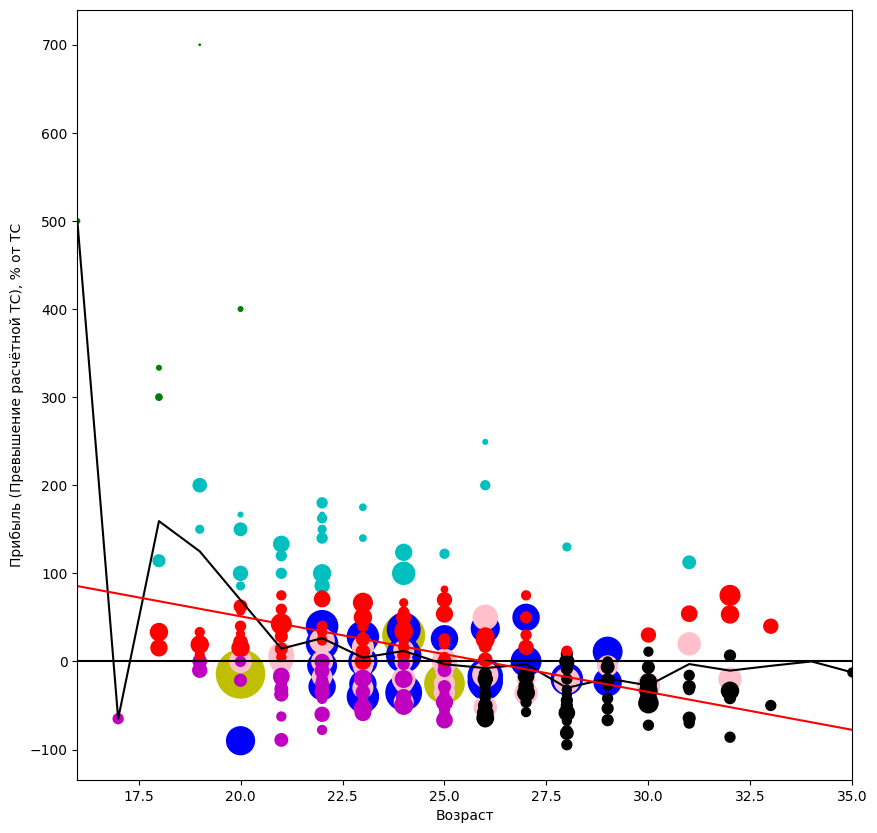

In [161]:
# Зависимость прибыли от возраста
plt.figure(figsize=(10, 10))
plt.scatter(age, profit_pct, s=[10 * int(x) + 1 for x in theory], c=color_codes)
cost_lim = [min(min(theory), min(practice)), max(max(theory), max(practice))]
plt.plot(age_limit, [1, 1], c='black')
plt.xlim(age_limit)
plt.xlabel('Возраст')
plt.ylabel('Прибыль (Превышение расчётной ТС), % от ТС')

# Средняя прибыль по возрасту
by_age = [[] for i in range(age_limit[0], age_limit[1] + 1)]
for i in range(len(age)):
  by_age[age[i] - age_limit[0]].append(profit_pct[i])
by_age_mean = [sum(x) / max(len(x), 1) for x in by_age]
plt.plot(range(age_limit[0], age_limit[1] + 1), by_age_mean, c='black')

age_index = 24 - age_limit[0]
print(*('Шанс продать Тики дороже трёшки: ', len([x for x in by_age[age_index] if x > 20]), ' из ', len(by_age[age_index])))

# Линейная регрессия прибыли от возраста
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.array(age).reshape(-1, 1), np.array(profit_pct).reshape(-1, 1))
plt.plot(age_limit, reg.predict(np.array(age_limit).reshape(-1, 1)), c='red')

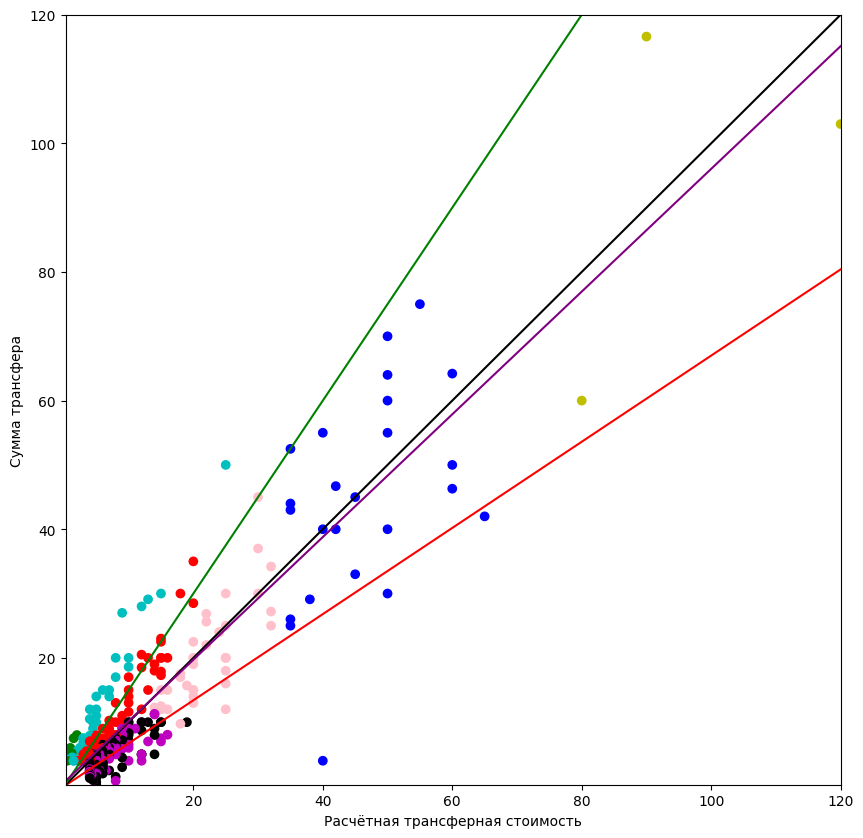

In [160]:
# зависимость расчетной трансферной стоимости и суммы трансфера
plt.figure(figsize=(10, 10))
plt.scatter(theory, practice, c=color_codes)
plt.xlabel('Расчётная трансферная стоимость')
plt.ylabel('Сумма трансфера')
coefs = [0.67, 1, 1.5]
coef_colors = ['r', 'k', 'g']
for i in range(len(coefs)):
  coef = coefs[i]
  plt.plot(cost_lim, [cost_lim[0] * coef, cost_lim[1] * coef], c=coef_colors[i])
plt.xlim(cost_lim)
plt.ylim(cost_lim)

# Линейная регрессия суммы трансфера от ТС
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.array(theory).reshape(-1, 1), np.array(practice).reshape(-1, 1))
plt.plot(cost_lim, reg.predict(np.array(cost_lim).reshape(-1, 1)), c='purple')

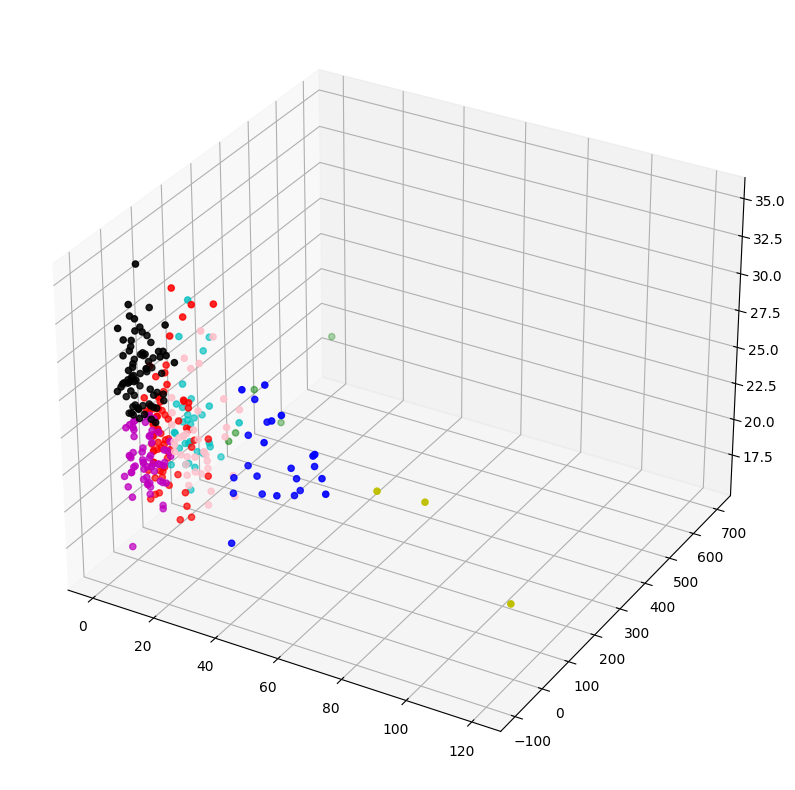

In [153]:
# зависимость расчетной и реальной трансферной стоимости
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(theory, profit_pct, age, c=color_codes)

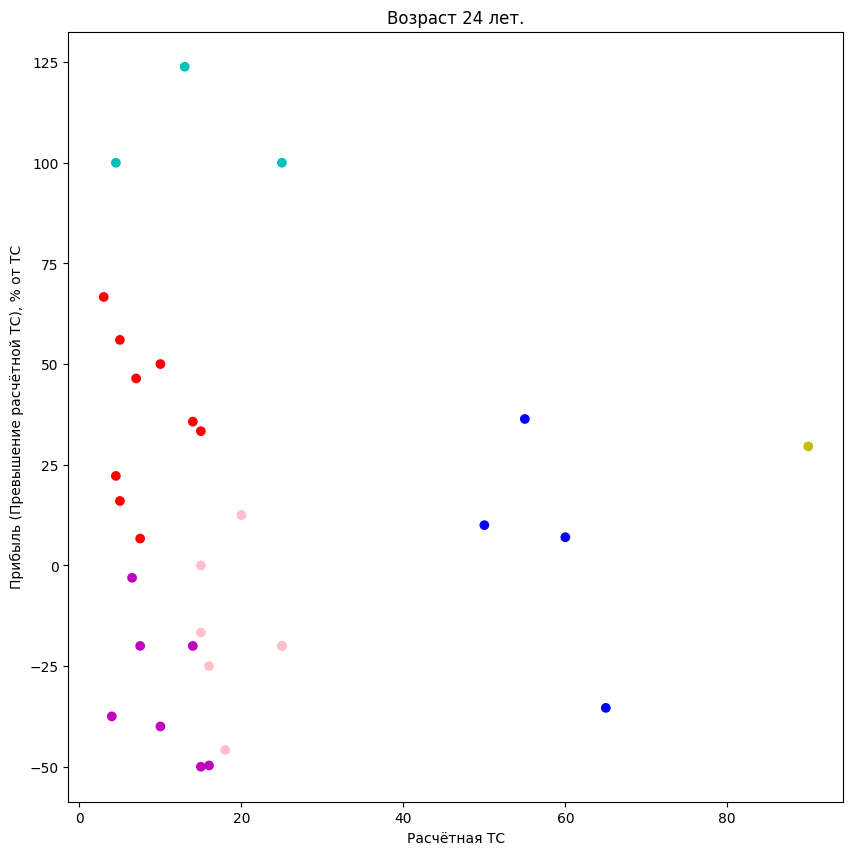

In [164]:
for cur_age in [24]: # range(age_limit[0], age_limit[1] + 1):
  age_inds = [i for i in range(len(age)) if age[i] == cur_age]
  age_theory = [theory[i] for i in age_inds]
  age_profit = [profit_pct[i] for i in age_inds]
  age_color = [color_codes[i] for i in age_inds]
  plt.figure(figsize=(10, 10))
  plt.title('Возраст ' + str(cur_age) + ' лет.')
  plt.scatter(age_theory, age_profit, c=age_color)
  plt.xlabel('Расчётная ТС')
  plt.ylabel('Прибыль (Превышение расчётной ТС), % от ТС')

In [143]:
print(age_limit, cost_lim)

[16, 35] [0.273, 120.0]
